In [73]:
# Imports
import numpy as np
import scipy.optimize as opt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")
%matplotlib inline

# Lecture 10: Optimization II

## Topics

I. Solving Optimization Problems

II. Preserving Convexity

III. Linear Programming Theory

* Formulation
* Duality
* Solution Methods
    * Simplex Method
    * Primal-Dual Interior-Point Method 

IV. Asset Liability Management: Cash-Flow Matching

* Basic setup
* Example
* Nonlinear scenario
* Stochastic liabilities


V. Fitting the Volatility Surface

* Downloading option data
* First visualization
* Second visualization

# Types of Optimization

## Machine Learning

Minimizes a loss function $L$ by finding the best function $f$ that predicts target $Y$ from features $X$. A good model has a low loss on the test data.

$$
\text{arg } \min_f L(X,Y, f(X))
$$

## Statistical Inference

Fits the best parameters of a chosen probability distribution for variables $X$. A good model has a high goodness of fit (*i.e.* the data fit the distribution).

$$
\text{arg } \max_{\theta} \text{Pr}\,(\theta, X)
$$

## Bayesian Inference

Assumes that the distribution parameters $\theta$ are random variables with a prior distribution. A good model has a high posterior probability (Bayes factor).

$$
\text{Pr}\, (\theta | X) = \frac{\text{Pr}\, (X |\theta) \, \text{Pr}\, (\theta)}{\text{Pr}\, (\theta)}
$$


# Solving Optimization Problems

Optimization is more art than science. You have to choose both the correct problem to solve, the correct optimizer, the correct starting point, and the correct bounds. You should think of optimization as a tool to **help** you get to the solution, not as something that produces the "answer" to your problem. Never just believe the solution an optimizer (of any kind) produces -- test the solution. And before you use any optimizer, it is a good idea to test it on a problem where you know the solution (maybe an analytical solution).

**If** you can plot your problem, you should. Your eye probably provides the best approximate solution for low dimensional problems. Even using contour plots can help.

Standard diagnostic tools for optimization:
* Eye-squared -- look at the plotted solution against the objective
* Run the optimization several times to see if it produces consistent results
* Change the starting values several times to see if it produces consistent results
* Analyze a log of intermediate results per iteration -- does it converge in a way that makes sense?
* Look at the covariance matrix, the Jacobian, and the Hessian (whichever makes sense in the context of the problem) -- what is the condition number? Can you trust its stability?


Finally, size of the problem and time complexity may not be under your control.

<center><img src = "exponential_functions.svg" height=700 width=700></center>

 A log-log-scaled plot of different functions (including polynomially and exponentially growing ones as well as the factorial) to illustrate the speed of growth of these functions.
 
Figure from [Institute of Applied Optimization](http://iao.hfuu.edu.cn/blogs/25-what-is-optimization#:~:text=5.-,Summary,approximate%20solutions%20in%20reasonable%20time.)

## Look at Contour Plots

Let's look at a two-dimensional Rosenbrock function. That way we can see the contour plot along with the solution. The solution is a small area that is marked with a red circle. As you recall, the solution is at (1.0, 1.0) for the two-dimensional function.

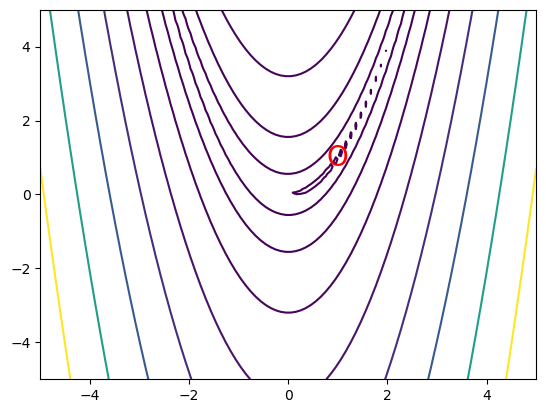

In [2]:
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
Z = opt.rosen(np.vstack([X.ravel(), Y.ravel()])).reshape((100,100))

# Note: the global minimum is at (1,1) in a tiny contour island
plt.contour(X, Y, Z, np.arange(10)**5)
plt.text(1, 1, 'O', va='center', ha='center', color='red', fontsize=20);

## Look at the Path of Optimization

Looking at the path the optimizer takes can be illuminating. For that we build a reporter function.

In [3]:
def reporter(p):
    """Reporter function to capture intermediate states of optimization."""
    global ps
    ps.append(p)

In [4]:
# Initial starting position
x0 = np.array([4,-4.1])

We can see the solution and the path of the **Nelder-Mead optimizer**.

In [5]:
ps = [x0]
opt.minimize(opt.rosen, x0, method='nelder-mead', callback=reporter)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 5.262756878429089e-10
             x: [ 1.000e+00  1.000e+00]
           nit: 85
          nfev: 162
 final_simplex: (array([[ 1.000e+00,  1.000e+00],
                       [ 9.999e-01,  9.999e-01],
                       [ 1.000e+00,  1.000e+00]]), array([ 5.263e-10,  3.875e-09,  1.061e-08]))

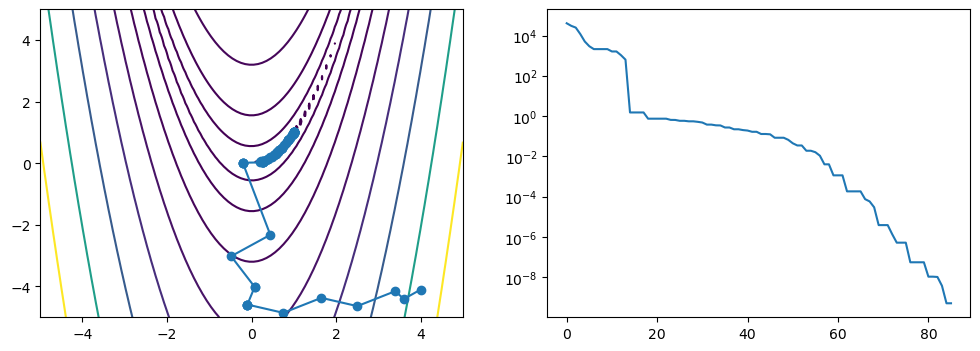

In [6]:
ps = np.array(ps)
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.contour(X, Y, Z, np.arange(10)**5)
plt.plot(ps[:, 0], ps[:, 1], '-o')
plt.subplot(122)
plt.semilogy(range(len(ps)), opt.rosen(ps.T));

Similarly for the **Newton-CG method**.

In [7]:
ps = [x0]
opt.minimize(opt.rosen, x0, method='Newton-CG', jac=opt.rosen_der, hess=opt.rosen_hess, callback=reporter)

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 1.3642782750354208e-13
       x: [ 1.000e+00  1.000e+00]
     nit: 26
     jac: [ 1.212e-04 -6.085e-05]
    nfev: 38
    njev: 38
    nhev: 26

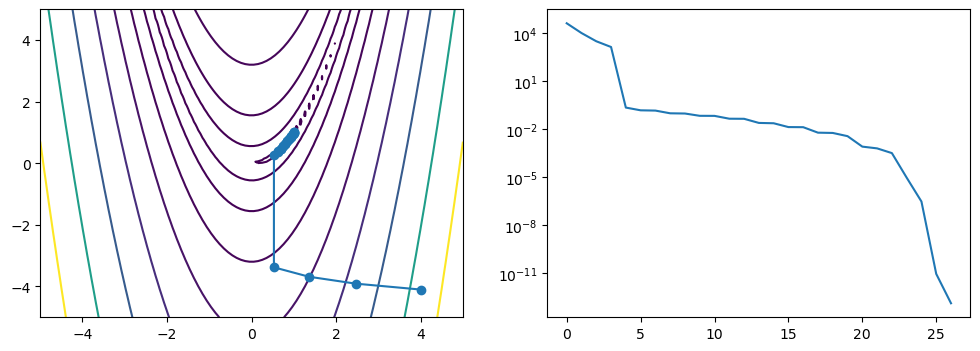

In [8]:
ps = np.array(ps)
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.contour(X, Y, Z, np.arange(10)**5)
plt.plot(ps[:, 0], ps[:, 1], '-o')
plt.subplot(122)
plt.semilogy(range(len(ps)), opt.rosen(ps.T));

And the BFGS method.

In [9]:
ps = [x0]
opt.minimize(opt.rosen, x0, method='BFGS',jac=opt.rosen_der, callback=reporter)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 5.360309305083205e-16
        x: [ 1.000e+00  1.000e+00]
      nit: 55
      jac: [ 1.952e-07 -7.474e-08]
 hess_inv: [[ 4.950e-01  9.903e-01]
            [ 9.903e-01  1.986e+00]]
     nfev: 72
     njev: 72

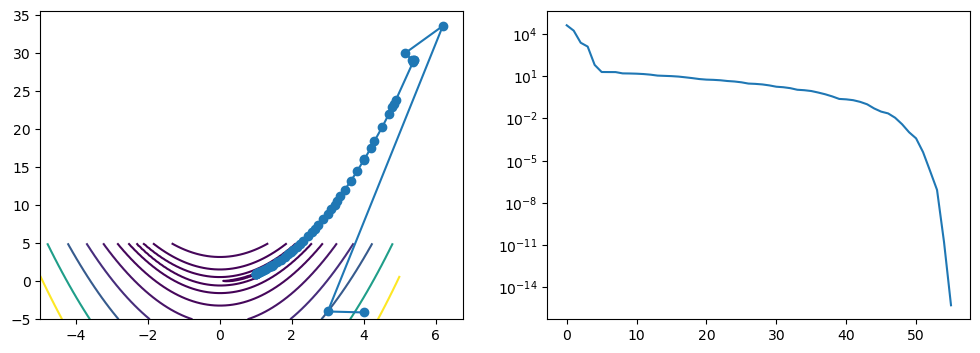

In [10]:
ps = np.array(ps)
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.contour(X, Y, Z, np.arange(10)**5)
plt.plot(ps[:, 0], ps[:, 1], '-o')
plt.subplot(122)
plt.semilogy(range(len(ps)), opt.rosen(ps.T));

We can also build our own optimization function based on **gradient descent**.

In [11]:
# Note, that this is NOT a general minimization function!

def custmin(fun, x0, args=(), maxfev=None, alpha=0.0002,
        maxiter=100000, tol=1e-10, callback=None, **options):
    """Implements simple gradient descent for the Rosen function."""
    best_x = x0
    best_y = fun(x0)
    funcalls = 1
    niter = 0
    improved = True
    stop = False

    while improved and not stop and niter < maxiter:
        niter += 1
        # the next 2 lines are gradient descent
        step = alpha * opt.rosen_der(best_x)
        best_x = best_x - step

        best_y = fun(best_x)
        funcalls += 1

        if np.linalg.norm(step) < tol:
            improved = False
        if callback is not None:
            callback(best_x)
        if maxfev is not None and funcalls >= maxfev:
            stop = True
            break

    return opt.OptimizeResult(fun=best_y, x=best_x, nit=niter,
                              nfev=funcalls, success=(niter > 1))

In [12]:
ps = [x0]
opt.minimize(opt.rosen, x0, method=custmin, callback=reporter)

 success: True
     fun: 1.060466347344834e-08
       x: [ 9.999e-01  9.998e-01]
     nit: 100000
    nfev: 100001

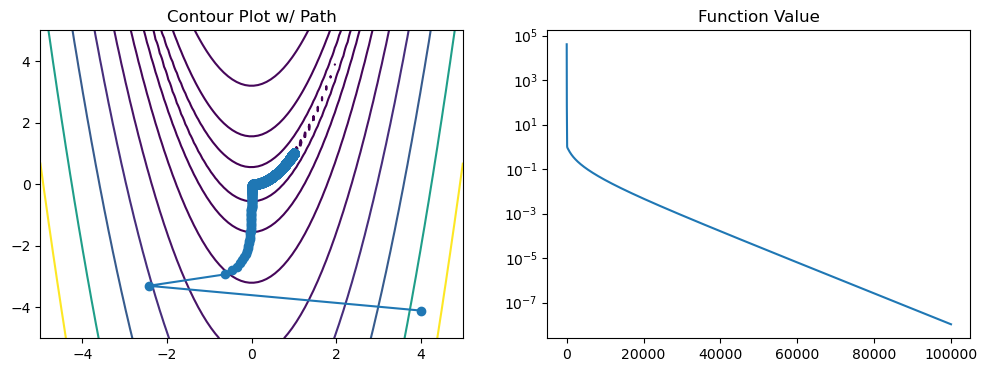

In [13]:
ps = np.array(ps)
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.contour(X, Y, Z, np.arange(10)**5)
plt.plot(ps[:, 0], ps[:, 1], '-o')
plt.title('Contour Plot w/ Path')
plt.subplot(122)
plt.semilogy(range(len(ps)), opt.rosen(ps.T))
plt.title('Function Value');

## Another Look at Constrained Optimization

Consider the function:
$$
f(x_0, x_1) = -( 2 x_0 x_1 + 2 x_0 - x_0^2 - 2 x_1^2)
$$

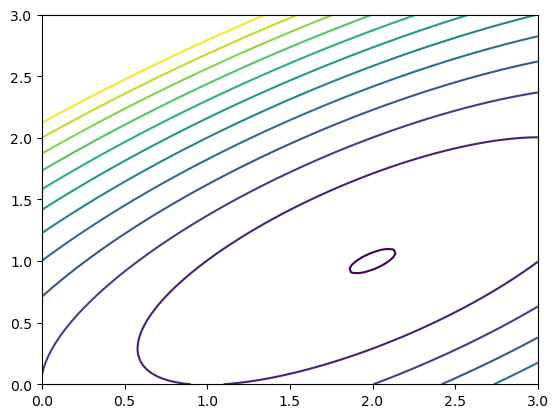

In [14]:
def f(x):
    return -(2*x[0]*x[1] + 2*x[0] - x[0]**2 - 2*x[1]**2)

x = np.linspace(0, 3, 100)
y = np.linspace(0, 3, 100)
X, Y = np.meshgrid(x, y)
Z = f(np.vstack([X.ravel(), Y.ravel()])).reshape((100,100))
plt.contour(X, Y, Z, np.arange(-1.99,10, 1));

Now add constraints and bounds:

Constraints:
$$
x_0^3 - x_1 = 0
$$
$$
x_1 - (x_0 -1)^4 - 2 \ge 0
$$

Bounds:
$$
0.5 \le x_0 \le 1.5
$$
$$
1.5 \le x_1 \le 2.5
$$

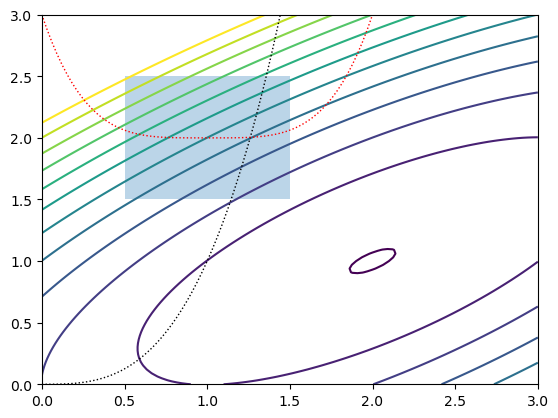

In [15]:
def f(x):
    return -(2*x[0]*x[1] + 2*x[0] - x[0]**2 - 2*x[1]**2)

x = np.linspace(0, 3, 100)
y = np.linspace(0, 3, 100)
X, Y = np.meshgrid(x, y)
Z = f(np.vstack([X.ravel(), Y.ravel()])).reshape((100,100))
plt.contour(X, Y, Z, np.arange(-1.99,10, 1));
plt.plot(x, x**3, 'k:', linewidth=1) # first constraint in black
plt.plot(x, (x-1)**4+2, 'r:', linewidth=1) # second constraint in red
plt.fill([0.5,0.5,1.5,1.5], [2.5,1.5,1.5,2.5], alpha=0.3) # bounds shaded
plt.axis([0,3,0,3]);

In [16]:
# Define our constraints, bounds, and a starting point
cons = ({'type': 'eq',
         'fun' : lambda x: np.array([x[0]**3 - x[1]]),
         'jac' : lambda x: np.array([3.0*(x[0]**2.0), -1.0])},
        {'type': 'ineq',
         'fun' : lambda x: np.array([x[1] - (x[0]-1)**4 - 2])})

bnds = ((0.5, 1.5), (1.5, 2.5))

x0 = [0, 2.5] # starting point

In [17]:
# Optimize without constraints
ux = opt.minimize(f, x0, constraints=None)
ux

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -1.9999999999996365
        x: [ 2.000e+00  1.000e+00]
      nit: 5
      jac: [ 1.252e-06 -1.416e-06]
 hess_inv: [[ 9.983e-01  5.011e-01]
            [ 5.011e-01  4.994e-01]]
     nfev: 18
     njev: 6

In [18]:
# Optimize with constraints
cx = opt.minimize(f, x0, bounds=bnds, constraints=cons)
cx

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 2.049915472024102
       x: [ 1.261e+00  2.005e+00]
     nit: 6
     jac: [-3.487e+00  5.497e+00]
    nfev: 19
    njev: 6

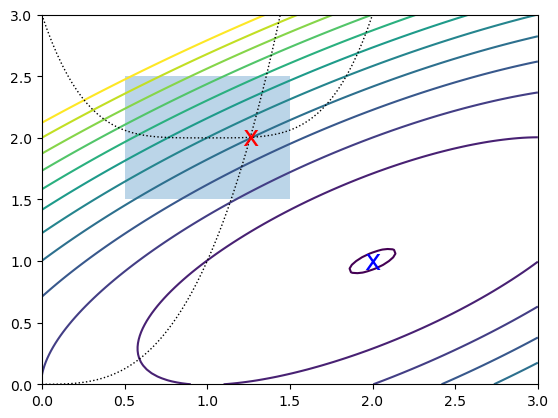

In [19]:
x = np.linspace(0, 3, 100)
y = np.linspace(0, 3, 100)
X, Y = np.meshgrid(x, y)
Z = f(np.vstack([X.ravel(), Y.ravel()])).reshape((100,100))
plt.contour(X, Y, Z, np.arange(-1.99,10, 1));
plt.plot(x, x**3, 'k:', linewidth=1) # first constraint
plt.plot(x, (x-1)**4+2, 'k:', linewidth=1) # second constraint
plt.text(ux['x'][0], ux['x'][1], 'x', va='center', ha='center', size=20, color='blue')
plt.text(cx['x'][0], cx['x'][1], 'x', va='center', ha='center', size=20, color='red')
plt.fill([0.5,0.5,1.5,1.5], [2.5,1.5,1.5,2.5], alpha=0.3) # bounds
plt.axis([0,3,0,3]);

## Optimizers can also be used for Curve Fitting and Estimation

Here we have a function:
$$
g(x,a,b,f,\phi) = a e^{-b \sin (f x + \phi)}
$$
with true, unknown parameters:
$$
x =3
$$
$$
a = 2
$$
$$
b = 1
$$
$$
\phi = \frac{\pi}{4}
$$

We create the function add random noise and use an optimizer to fit the noisy data to the function and estimate the parameters.

In [20]:
import scipy.optimize as opt
import scipy.stats as stats
import numpy as np
import warnings
warnings.simplefilter("ignore")

# Define the function to fit.
def function(x, a, b, f, phi):
    result = a * np.exp(-b * np.sin(f * x + phi))
    return result

In [21]:
# Create a noisy data set around the actual parameters
true_params = [3, 2, 1, np.pi/4]
print("target parameters: {}".format(true_params))
x = np.linspace(0, 2*np.pi, 25)
exact = function(x, *true_params)
noisy = exact + 0.3*stats.norm.rvs(size=len(x))

# Use curve_fit to estimate the function parameters from the noisy data.
initial_guess = [1,1,1,1]
estimated_params, err_est = opt.curve_fit(function, x, noisy, p0=initial_guess)
print("solved parameters: {}".format(estimated_params))

# err_est is an estimate of the covariance matrix of the estimates
print("variance: {}".format(err_est.diagonal()))

target parameters: [3, 2, 1, 0.7853981633974483]
solved parameters: [2.59205751 2.1479563  0.95014529 0.97756014]
variance: [0.13343069 0.01948401 0.00135332 0.02094279]


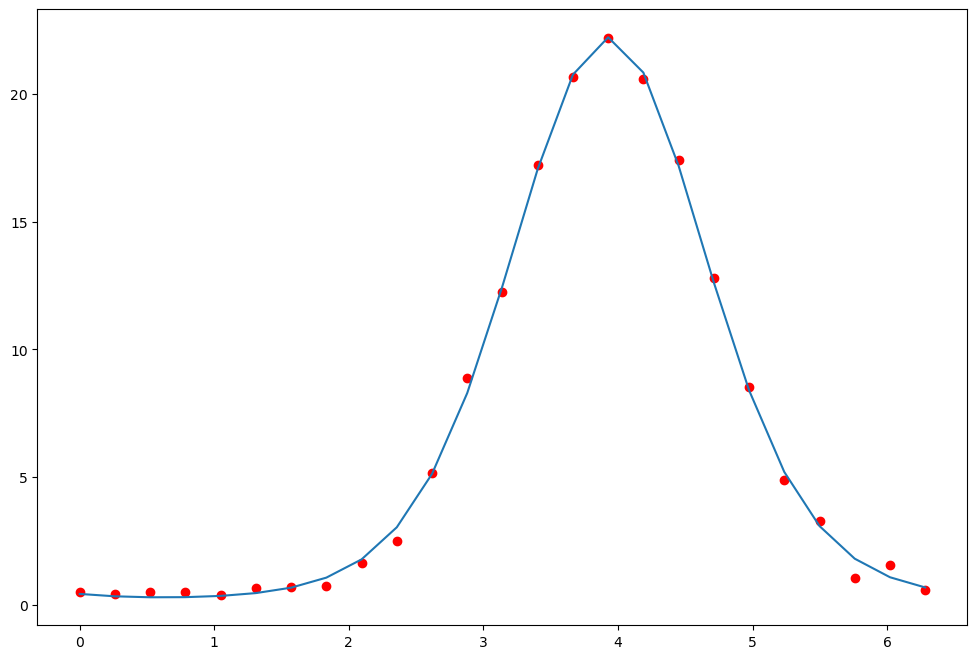

In [22]:
fig = plt.figure(figsize=(12,8))
plt.plot(x, noisy, 'ro')
plt.plot(x, function(x, *estimated_params));

Another curve fitting. We have a function:
$$
y = f(x) = 1.5 e^{-0.2 x} + 0.3
$$

Add random noise to the data and fit both a linear model and a quadratic model.

In [23]:
import numpy as np
import scipy.stats as stats

# Create clean data.
x = np.linspace(0, 4.0, 100)
y = 1.5 * np.exp(-0.2 * x) + 0.3

In [24]:
# Add a bit of noise.
noise = 0.1 * stats.norm.rvs(size=100)
noisy_y = y + noise

In [25]:
# Fit noisy data with a linear model.
linear_coef = np.polyfit(x, noisy_y, 1)
linear_poly = np.poly1d(linear_coef)
linear_y = linear_poly(x)

In [26]:
# Fit noisy data with a quadratic model.
quad_coef = np.polyfit(x, noisy_y, 2)
quad_poly = np.poly1d(quad_coef)
quad_y = quad_poly(x)

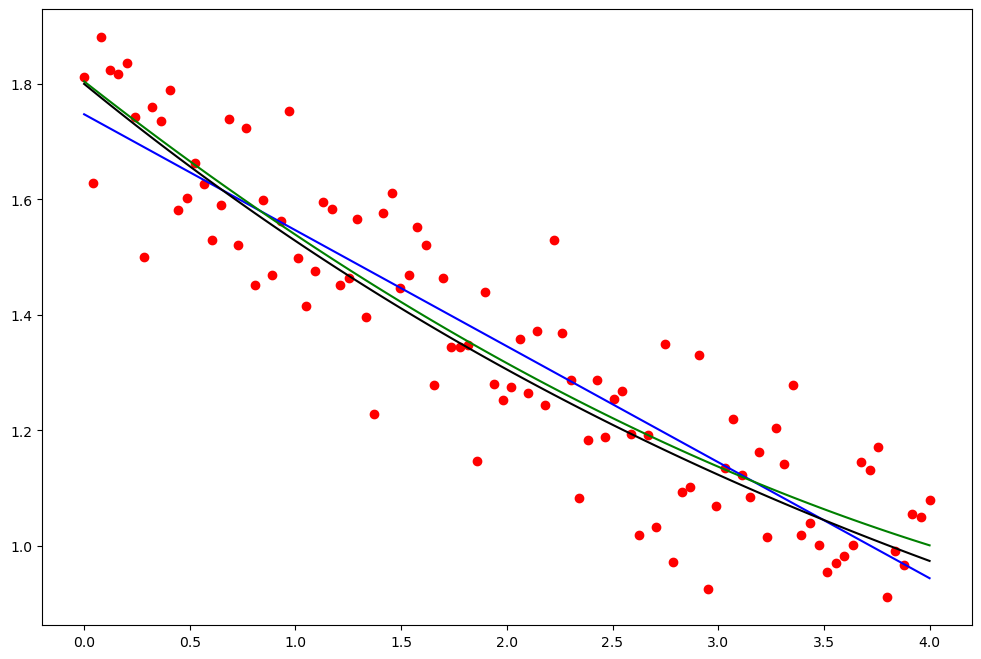

In [27]:
fig = plt.figure(figsize=(12,8))
plt.plot(x, noisy_y, 'ro') # noisy data
plt.plot(x, linear_y, color='b') # linear solution
plt.plot(x, quad_y, color='g') # quadratic solution
plt.plot(x, y,'-', color = 'k'); # actual data

# Operations that preserve convexity

* The intersection of convex sets is convex.
* All affine functions (scaling, translation, projection) applied to a convex set will be convex.
* The perspective function of a convex set will be convex (this normalizes vectors so the last component is 1 and then drops the last component, it essentially maps $\mathbb{R}^{n+1}$ into $\mathbb{R}^{n}$).
* Linear-fractional functions applied to convex sets are convex (this is a perspective map composed with an affine function $f(\mathbf{x}) = \frac{A \mathbf{x} + \mathbf{b}}{c^T \mathbf{x} + d}$, for example, if you have a distribution function that is convex, conditional distributions formed from that distribution function will be convex).

**Note**: This (and the examples below) do not represent an exhaustive list (see *e.g.* [*Convex Optimization*](https://web.stanford.edu/~boyd/cvxbook/) by Stephen Boyd and Lieven Vandenberghe).

### Some Examples on $\mathbb{R}$
The following functions are convex:
* affine: $f(x) = a x + b$ on $\mathbb{R}$ where $ a, b \in \mathbb{R}$ 
* exponential: $f(x) = {e}^{\alpha x}$ for any $\alpha \in \mathbb{R}$
* powers: $f(x) = x^\alpha$ on $\mathbb{R}_{++}$ where $\alpha \ge 1$ or $\alpha \le 0$
* powers of absolute value: $f(x) = |x|^p$ on $\mathbb{R}$, for $p \ge 1$
* negative entropy: $f(x) = x \log x$ on $\mathbb{R}_{++}$

The following functions are concave:
* affine: $f(x) = a x + b$ where $ a, b \in \mathbb{R}$
* powers: $f(\mathbf{x}) = x^\alpha$ on $\mathbb{R}_{++}$ where $0 \le \alpha \le 1$
* logarithm: $f(x) =  \log x$ on $\mathbb{R}_{++}$


And...?

### Some Examples on $\mathbb{R}^n$ and $\mathbb{R}^{m \times n}$
* affine functions are convex and concave
* all norms are convex

#### Examples on $\mathbb{R}^n$
* affine function: $f(\mathbf{x}) = A^T \mathbf{x} + \mathbf{b}$
* norms: $||x||_p = (\sum_{i=1}^n |x_i|^p)^{1/p}$ for $p \ge 1; \; ||x||_\infty
= \max_k |x_k|$

#### Examples on $\mathbb{R}^{m \times n}$ ($m \times n$ matrices)
* affine function: $f(X) = \text{tr}\,(A^T X) + b = \sum_{i=1}^m \sum_{j=1}^n A_{ij} X_{ij} + b$
* spectral norm: $f(X) = ||X||_2 = \sigma_{\text{max}}(X) = (λ_{\text{max}}(X^T X))^{1/2}$. The spectral norm is the maximum singular value of a matrix (*i.e* the maximum "scale" by which the matrix can "stretch" a vector.

# Linear Programming Theory


## Formulation

\begin{aligned}
\min_{\mathbf{x} \in \mathbb{R}^n } \;\; & \mathbf{c}^T \mathbf{x}
\\
s.t. \;\;A \mathbf{x}  &\geq \mathbf{b;\;}
x_j \geq 0, \;\forall j
\end{aligned}


* Simpler than any other optimization problem

* With plenty of Finance applications






## Duality

Primal (**P**)

$$
\begin{aligned}
\min_{\mathbf{x} \in \mathbb{R}^n } \;\; & \mathbf{c}^T \mathbf{x}
\\
s.t. \;\; \mathbf{A} \mathbf{x}  \geq \mathbf{b};\;
& x_j \geq 0, \;\forall j = 1,\dots, n
\end{aligned}
$$


Dual (**D**)

$$
\begin{aligned}
\max_{\mathbf{y} \in \mathbb{R}^m } \;\; & \mathbf{b}^T \mathbf{y}
\\
s.t. \;\;\mathbf{A}^T\mathbf{y}  \leq \mathbf{c}; \;\;
& y_k \geq 0, \;\; \forall k = 1, \dots, m
\end{aligned}
$$


### Derivation

Lagrangian:

$$
\begin{align}  
\mathcal{L} (\mathbf{x}, \mathbf{y}, \mathbf{w}) & = & \mathbf{c}^T \mathbf{x} + \mathbf{y}^T (\mathbf{b}- A \mathbf{x}) - \mathbf{w}^T\mathbf{x} \\
& = & \mathbf{y}^T \mathbf{b} + (\mathbf{c}^T  - \mathbf{y}^T A - \mathbf{w}^T)\,\mathbf{x} \\
& & \text{with} \;\; \mathbf{y} \geq \mathbf{0}, \;\;\; \mathbf{w} \geq \mathbf{0}
\end{align}
$$

Lagrangian dual function

$$
\hat{f}(\mathbf{y}, \mathbf{w}) = \inf_{\mathbf{x}\in \mathbb{D}}\; \mathcal{L}(\mathbf{x}, \mathbf{y}, \mathbf{w}) =\mathbf{y}^T\mathbf{b} + \inf_{\mathbf{x}\in\mathbb{D}}  (\mathbf{c}^T  - \mathbf{y}^T A - \mathbf{w}^T)\,\mathbf{x}
$$

Obviously the last term is linear in $\mathbf{x}$, so the only feasible solution  where an infimum can be reached is when the term multiplying $\mathbf{x}$ is zero:

$$
\mathbf{c}  - A^T \mathbf{y} - \mathbf{w} = 0
$$

dropping the unused slack variable $\mathbf{w}$ will generate the dual problem (**D**).



### Duality Theorem:

   * If $\mathbf{x}$ is feasible for **P** and $\mathbf{y}$ is feasible for **D**, then $\mathbf{c}^T \mathbf{x} \geq \mathbf{b}^T \mathbf{y}$, 
    and only at optimality the equality holds $\mathbf{c}^T \mathbf{x}^* = \mathbf{b}^T \mathbf{y}^*$ .


* The quantity: $\mathbf{c}^T \mathbf{x} - \mathbf{b}^T \mathbf{y}$  is called **duality gap**. This value is used commonly as the stopping criteria for Interior LP method.


## Solution Methods

* **Simplex** ([Dantzig](https://en.wikipedia.org/wiki/George_Dantzig) 1947)

* **Ellipsoid** ([Khachiyan](https://en.wikipedia.org/wiki/Leonid_Khachiyan) 1979, proved that this algorithm could solve LP problems in **polynomial time**)

* **Interior Point**  ([Karmarkar](https://en.wikipedia.org/wiki/Narendra_Karmarkar) 1984, the first  **practical** polynomial time algorithm)
    * Projection method (Karmarkar 1984)
    * Affine Method (Dikin 1967)
    * Log-Barrier Method (many ...)






* **Interior Point** method has been extended to NLP problems, has been the focus of research for optimization in the last few decades.

* Although Interior Point is asymptotically superior, there is no clear winner between Simplex and Interior Point for LP problems: it depends on the problem as to which is faster.




### Simplex Methods

* Optimal points must be at the intersections of constraints:

<center><img src = "LP_GeomView.png" height=600 width=600></center>

#### Algorithm (Simplex Method)

* Input
\begin{aligned}
\\
\min_{\mathbf{x} \in \mathbb{R}^n } \;\;    &  \mathbf{c}^T \mathbf{x}
\\
s.t. \;\; \mathbf{x} \in \mathcal{P} & = \{\mathbf{x}: \mathbf{A}\mathbf{x}  \leq \mathbf{b}, \mathbf{x} \geq 0 \}
\end{aligned}


* Look at the [polytope](https://en.wikipedia.org/wiki/Convex_polytope) $\mathcal{P}$ as a graph $\mathcal{G} = (V,E)$ with $V$ as vertices and $E$ as edges.


* **Algorithm**
    1. Find any vertex $\mathbf{v}$ in  $\mathcal{P}$;
    2. While $\exists $ a neighbor $\mathbf{u}$ of $\mathbf{v}$ in $\mathcal{G}$ with $\mathbf{c}^T \mathbf{u} < \mathbf{c}^T \mathbf{v}$, set $\mathbf{v} = \mathbf{u}$;
    3. Output $\mathbf{v}$


The graphical strategy for solving linear programming problems relies on the idea that
the maximum value of the objective function will occur at a corner point of a bounded
feasible region. The Simplex Method or Interior Point Methods is no different, but we need to work with equations
for the border of the feasible region in matrix form. The trouble is that augmented
matrices are designed to solve equations and we have inequalities. For the graphical
strategy, we simply converted each inequality to an equation. For the Simplex Method,
we will introduce slack variables to change the inequalities to equalities. 

### Primal-dual Interior-point Method

For convenience, slightly reformulate the LP problem into an equivalent form

Primal (**P**)

\begin{aligned}
\min_{\mathbf{x} \in \mathbb{R}^n } \;\; &  \mathbf{c}^T \mathbf{x}
\\
s.t. \;\;  A\mathbf{x}  &= \mathbf{b}, \;\; \mathbf{x} \geq \mathbf{0}
\end{aligned}


Dual (**D**)
\begin{aligned}
\max_{\mathbf{y} \in \mathbb{R}^m } \;\; & \mathbf{b}^T \mathbf{y}
\\
s.t. \;\; A^T \mathbf{y} + \mathbf{s} & = \mathbf{c}, \;\; \mathbf{s} \geq \mathbf{0}
\end{aligned}







The optimality (KKT) conditions are

\begin{aligned} 
 A^T\mathbf{y}  + \mathbf{s} &= \mathbf{c}, 
\\
 A\mathbf{x}  &= \mathbf{b}, 
\\
 \mathbf{x}\circ \mathbf{s} &= \mathbf{0}, 
\\
\mathbf{x} \geq \mathbf{0}, \;\; \mathbf{s} &\geq \mathbf{0}
\end{aligned}

The third **complementary slackness** condition relates to the duality gap.






Primal-dual interior-point methods find primal-dual solutions $(\mathbf{x}^*, \mathbf{y}^*, \mathbf{s}^*)$ by applying variants of Newton's method to the first three KKT conditions above, and modifying search directions and step lengths, so that the last KKT condition is strictly satisfied at each iteration.

Rewrite the KKT conditions as:
$$
\begin{matrix}
F(\mathbf{x},\mathbf{y},\mathbf{s}) = \left[
\begin{matrix}
A^T\mathbf{y}  + \mathbf{s} - \mathbf{c} \\
A\mathbf{x}  - \mathbf{b} \\
X S \mathbf{e}
\end{matrix}
\right] = \mathbf{0}
\end{matrix}
$$

where $X, S$ are diagonal matrices, and $\mathbf{e}$ is the vector with all elements equal to 1.



The search direction is generated by solving,

$$
\begin{matrix}
\mathbf{F}'(\mathbf{x},\mathbf{y},\mathbf{s})  \left[
\begin{matrix}
\delta\mathbf{x} \\
\delta\mathbf{y} \\
\delta\mathbf{s}
\end{matrix}
\right] = \mathbf{F}(\mathbf{x},\mathbf{y},\mathbf{s})
\end{matrix}
$$

Looking for iterates that are strictly feasible, this becomes

$$
\begin{matrix}
\left[
\begin{matrix}
0 & A^T & I \\
A^T & 0 & 0  \\
S & 0 & X 
\end{matrix}
\right]
\left[
\begin{matrix}
\delta\mathbf{x} \\
\delta\mathbf{y} \\
\delta\mathbf{s}
\end{matrix}
\right]
= \left[
\begin{matrix}
\mathbf{0} \\
\mathbf{0} \\
-X S \mathbf{e}
\end{matrix}
\right] 
\end{matrix}
$$



In the Interior Point method, the critical concept is the central path: instead of the third KKT condition, the path of iterative points satisfies,

$$
x_i s_i = \tau\gamma, \;\;\; i=1,2,\cdots, n
$$

where $\tau\in  [0,1] $ is the centering parameter and $\gamma = \frac{\mathbf{s}^T\mathbf{x}}{n}$ is the duality gap parameter.

With this, the equation for search direction becomes

$$
\begin{matrix}
\left[
\begin{matrix}
0 & A^T & I \\
A^T & 0 & 0  \\
S & 0 & X 
\end{matrix}
\right]
\left[
\begin{matrix}
\delta\mathbf{x} \\
\delta\mathbf{y} \\
\delta\mathbf{s}
\end{matrix}
\right]
= \left[
\begin{matrix}
\mathbf{0} \\
\mathbf{0} \\
-\mathbf{X} \mathbf{S} \mathbf{e} + \tau\gamma \mathbf{e}
\end{matrix}
\right] \hspace{2in} (*)
\end{matrix}
$$


#### Algorithm (Primal-Dual Interior Point Method)

1. Determine $(\mathbf{x}^0, \mathbf{y}^0, \mathbf{s}^0)$ strictly feasible
2. Set k = 0
3. Do
    1. Set $\tau^k\in [0,1]$ and $\gamma^k = \frac{\mathbf{s}^T\mathbf{x}}{n}$
    2. Solve (*) for $(\delta\mathbf{x}^k, \delta\mathbf{y}^k, \delta\mathbf{s}^k)$
    3. Set $(\mathbf{x}^{k+1}, \mathbf{y}^{k+1}, \mathbf{s}^{k+1}) = (\mathbf{x}^k, \mathbf{y}^k, \mathbf{s}^k) + \alpha^k(\delta\mathbf{x}^k, \delta\mathbf{y}^k, \delta\mathbf{s}^k)$
       choosing $\alpha^k$ so that $(\mathbf{x}^{k+1}, \mathbf{s}^{k+1}) \geq 0 $
    4. k = k + 1
4. While  $\gamma^k > \epsilon$









**Software packages for LP**
* Most optimization packages will have the LP solver implemented, and generally include both the Simplex and Interior method.
* Here is the code applying the `scipy` LP optimizer to the example in the **geometric view** problem above.
$$
\min_{x_1,x_2}-2x_1 - 3x_2
$$
subject to:
$$
x_1 - 2 x_2 \le 4
$$
$$
2 x_1 + x_ 2 \le 18
$$
$$
x_2 \le 10
$$
$$
x_1,\, x_2 \ge 0
$$

In [28]:
import numpy as np
from scipy.optimize import linprog

c = np.array([-2, -3])
A = [[1, -2], [2, 1], [0, 1]]
b = np.array([4,18,10])
res = linprog(c, A, b,
                options={ 'disp': True})

print("The solution from Scipy Simplex method:", res.x)

The solution from Scipy Simplex method: [ 4. 10.]


#### A variety of approaches to an LP problem

Consider the following simple LP problem:
$$
\max_{x,y} x + 2 y
$$
subject to:
$$
\begin{aligned} 
 2 x + y &\le 20\;\;\; \text{red constraint}
\\
 -4x + 5y &\le 10\;\;\; \text{blue constraint}
\\
 -x + 2y &\le -2\;\;\;  \text{yellow constraint}
\\
x \geq 0, \;\; y &\geq 0
\end{aligned}
$$

We can plot this:


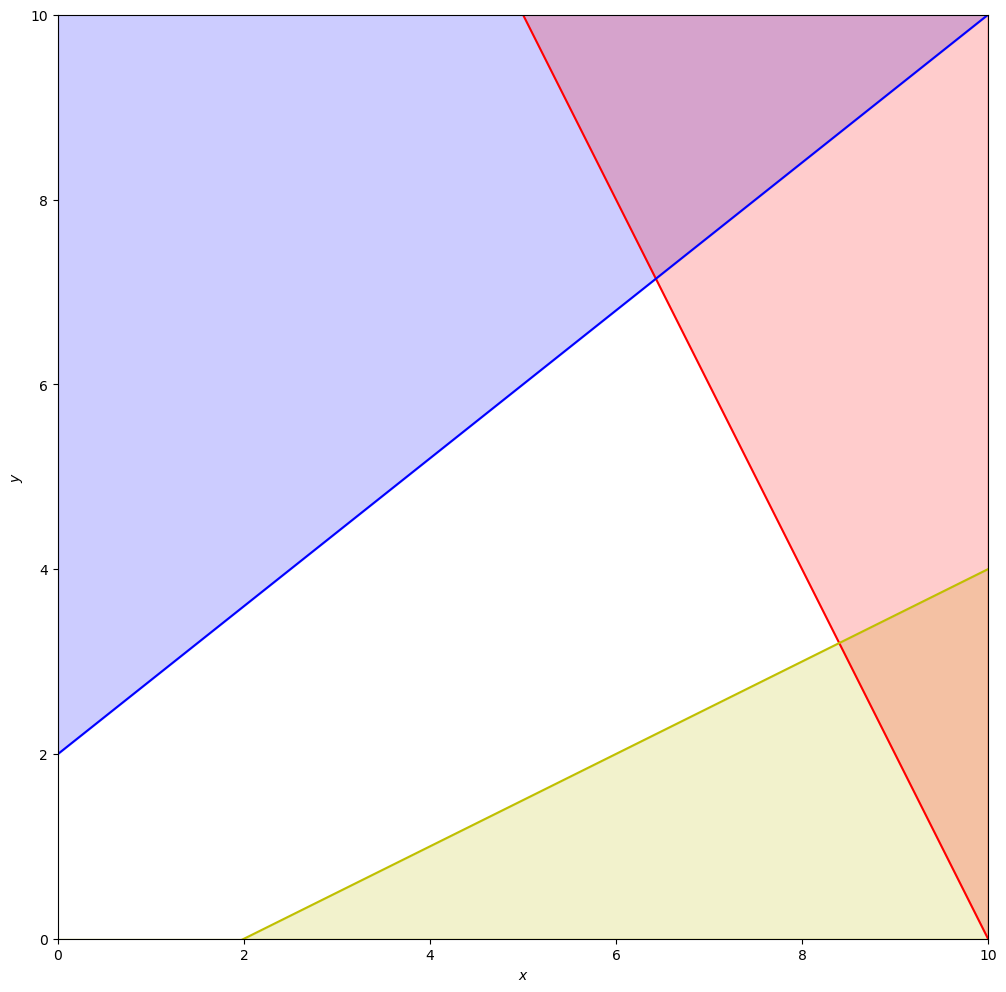

In [29]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")

# Define the lines forming the boundary
def f1(x):
    return 20 - 2*x
def f2(x):
    return (10 + 4*x)/5
def f3(x):
    return (-2 + x)/2

# Setting bounds
xr = np.linspace(0,10,100)
y1 = 10

plt.figure(figsize=(12,12))

# plot boundry lines
plt.plot(xr,f1(xr),'r')
plt.plot(xr,f2(xr),'b')
plt.plot(xr,f3(xr),'y')

# fill constraints
plt.fill_between(xr, f3(xr), interpolate=True, color='y', alpha=0.2)
plt.fill_between(xr, f2(xr), np.max(y1), color='b', alpha=0.2)
plt.fill_between(xr, f1(xr), np.max(y1), color='r', alpha=0.2)


plt.xlim(0,10)
plt.ylim(0,10);
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

Solve using `scipy`.

In [30]:
import scipy
from scipy.optimize import linprog

# Define the objective function
obj = [-1, -2]

# Define the constraints

# First the inequality constraints
lhs_ineq = [[ 2, 1], # Constraint 1 LHS
            [-4, 5], # Constraint 2 LHS
            [1, -2]] # Constraint 3 LHS

rhs_ineq = [20, # Constraint 1 RHS
            10, # Constraint 2 RHS
             2] # Constraint 3 RHS

# Now the equality constraints
#lhs_eq = [[-1, 5]]
#rhs_eq = [15]

# And the bounds
bnd = [(0, scipy.inf), # Bounds on x
       (0, scipy.inf)] # Bounds on y

#opt = linprog(c=obj, A_ub=lhs_ineq, b_ub=rhs_ineq,
#              A_eq=lhs_eq, b_eq=rhs_eq, bounds=bnd,
#              method='revised simplex')

opt_soln = linprog(c=obj, A_ub=lhs_ineq, b_ub=rhs_ineq,
              bounds=bnd, method='revised simplex')
soln_1 = opt_soln.x

opt_soln

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -20.714285714285715
       x: [ 6.429e+00  7.143e+00]
     nit: 2

Slack variables are used in particular in linear programming. As with the other variables in the augmented constraints, the slack variable **cannot take on negative values**, as the simplex algorithm requires them to be positive or zero. The slack variable is the difference between the right-hand side and the left-hand side of the constraint at the optimal solution.

* If a slack variable associated with a constraint is zero at a particular candidate solution, the constraint is binding there, as the constraint restricts the possible changes from that point.
* If a slack variable is positive at a particular candidate solution, the constraint is non-binding there, as the constraint does not restrict the possible changes from that point.
* If a slack variable is negative at some point, the point is infeasible (not allowed), as it does not satisfy the constraint.

Plot the solution:

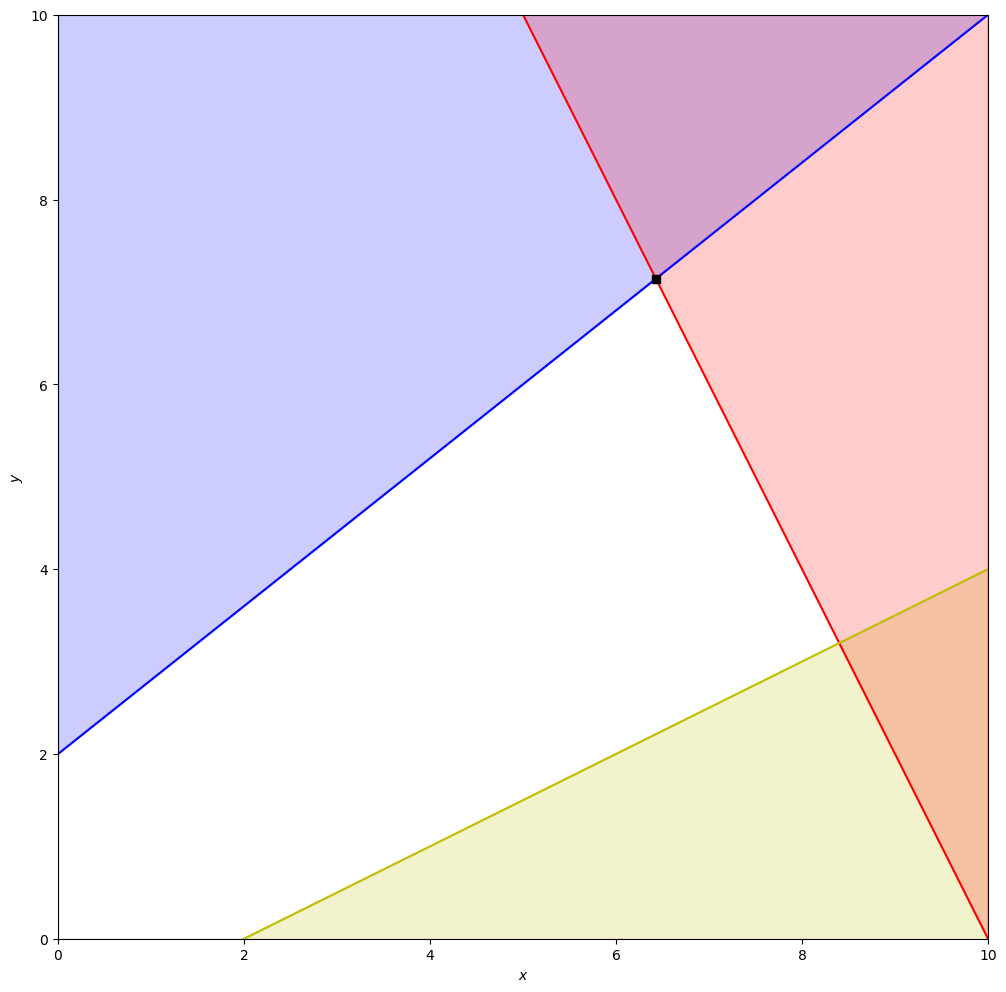

In [31]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Define the lines forming the boundary
def f1(x):
    return 20 - 2*x
def f2(x):
    return (10 + 4*x)/5
def f3(x):
    return (-2 + x)/2
def f4(x):
    return (15+x)/5

# Setting bounds
xr = np.linspace(0,10,100)
y1 = 10


plt.figure(figsize=(12,12))

# plot boundry lines
plt.plot(xr,f1(xr),'r')
plt.plot(xr,f2(xr),'b')
plt.plot(xr,f3(xr),'y')

# plot solution
plt.plot(soln_1[0],soln_1[1],'s',color = 'k')

# fill constraints
plt.fill_between(xr, f3(xr), interpolate=True, color='y', alpha=0.2)
plt.fill_between(xr, f2(xr), np.max(y1), color='b', alpha=0.2)
plt.fill_between(xr, f1(xr), np.max(y1), color='r', alpha=0.2)



plt.xlim(0,10)
plt.ylim(0,10);
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

Add an equality constraint to the problem:
$$
\max_{x,y} x + 2 y
$$
subject to:
$$
\begin{aligned} 
 2 x + y &\le 20\;\;\; \text{red constraint}
\\
 -4x + 5y &\le 10\;\;\; \text{blue constraint}
\\
 -x + 2y &\le -2\;\;\;  \text{yellow constraint}
\\
-x +5 y &= 15\;\;\;  \text{green line}
\\
x \geq 0, \;\; y &\geq 0
\end{aligned}
$$

We can plot this:


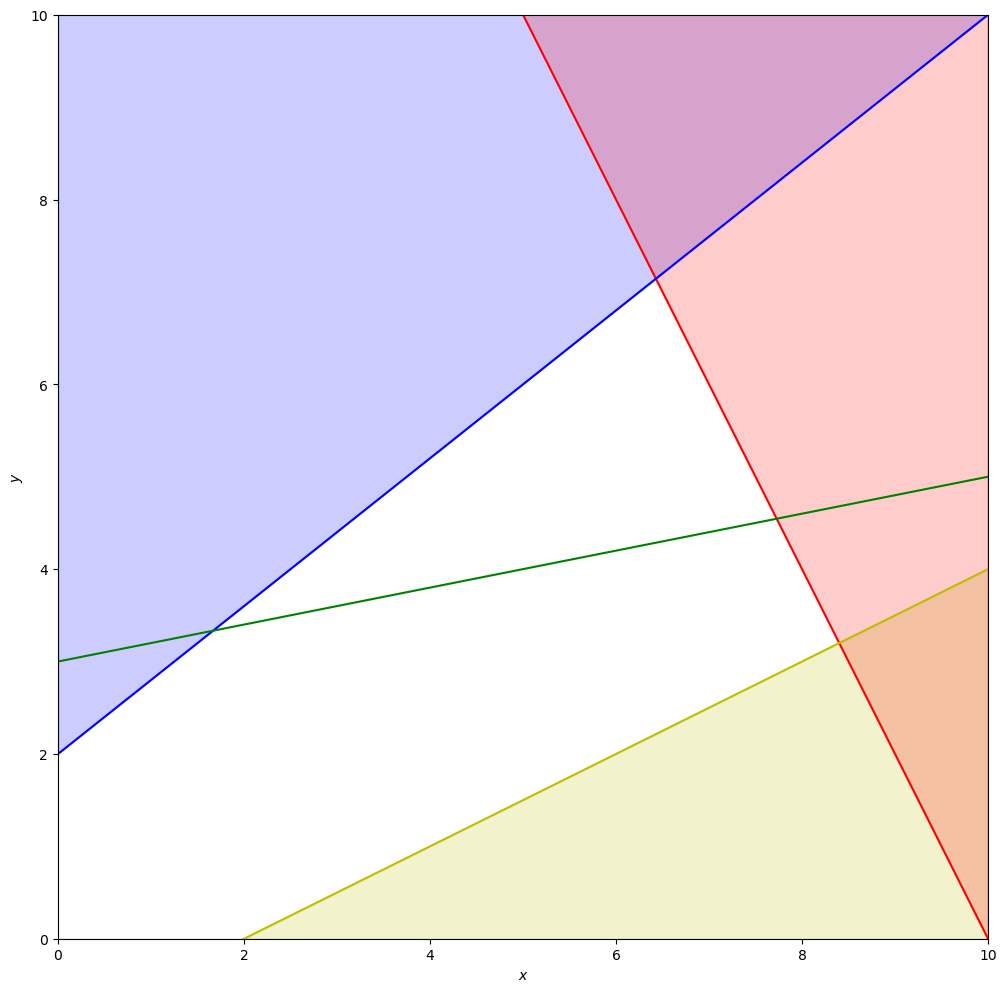

In [32]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Define the lines forming the boundary
def f1(x):
    return 20 - 2*x
def f2(x):
    return (10 + 4*x)/5
def f3(x):
    return (-2 + x)/2
def f4(x):
    return (15+x)/5

# Setting bounds
xr = np.linspace(0,10,100)
y1 = 10

plt.figure(figsize=(12,12))

# plot boundry lines
plt.plot(xr,f1(xr),'r')
plt.plot(xr,f2(xr),'b')
plt.plot(xr,f3(xr),'y')
plt.plot(xr,f4(xr), 'g')

# fill constraints
plt.fill_between(xr, f3(xr), interpolate=True, color='y', alpha=0.2)
plt.fill_between(xr, f2(xr), np.max(y1), color='b', alpha=0.2)
plt.fill_between(xr, f1(xr), np.max(y1), color='r', alpha=0.2)



plt.xlim(0,10)
plt.ylim(0,10);
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

In [33]:
import scipy
from scipy.optimize import linprog
import warnings
warnings.simplefilter("ignore")

# Define the objective function
obj = [-1, -2]

# Define the constraints

# First the inequality constraints
lhs_ineq = [[ 2, 1], # Constraint 1 LHS
            [-4, 5], # Constraint 2 LHS
            [1, -2]] # Constraint 3 LHS

rhs_ineq = [20, # Constraint 1 RHS
            10, # Constraint 2 RHS
             2] # Constraint 3 RHS

# Now the equality constraints
lhs_eq = [[-1, 5]]
rhs_eq = [15]

# And the bounds
bnd = [(0, scipy.inf), # Bounds on x
       (0, scipy.inf)] # Bounds on y

opt_soln = linprog(c=obj, A_ub=lhs_ineq, b_ub=rhs_ineq,
              A_eq=lhs_eq, b_eq=rhs_eq, bounds=bnd,
              method='revised simplex')

soln_2 = opt_soln.x

opt_soln

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -16.818181818181817
       x: [ 7.727e+00  4.545e+00]
     nit: 3

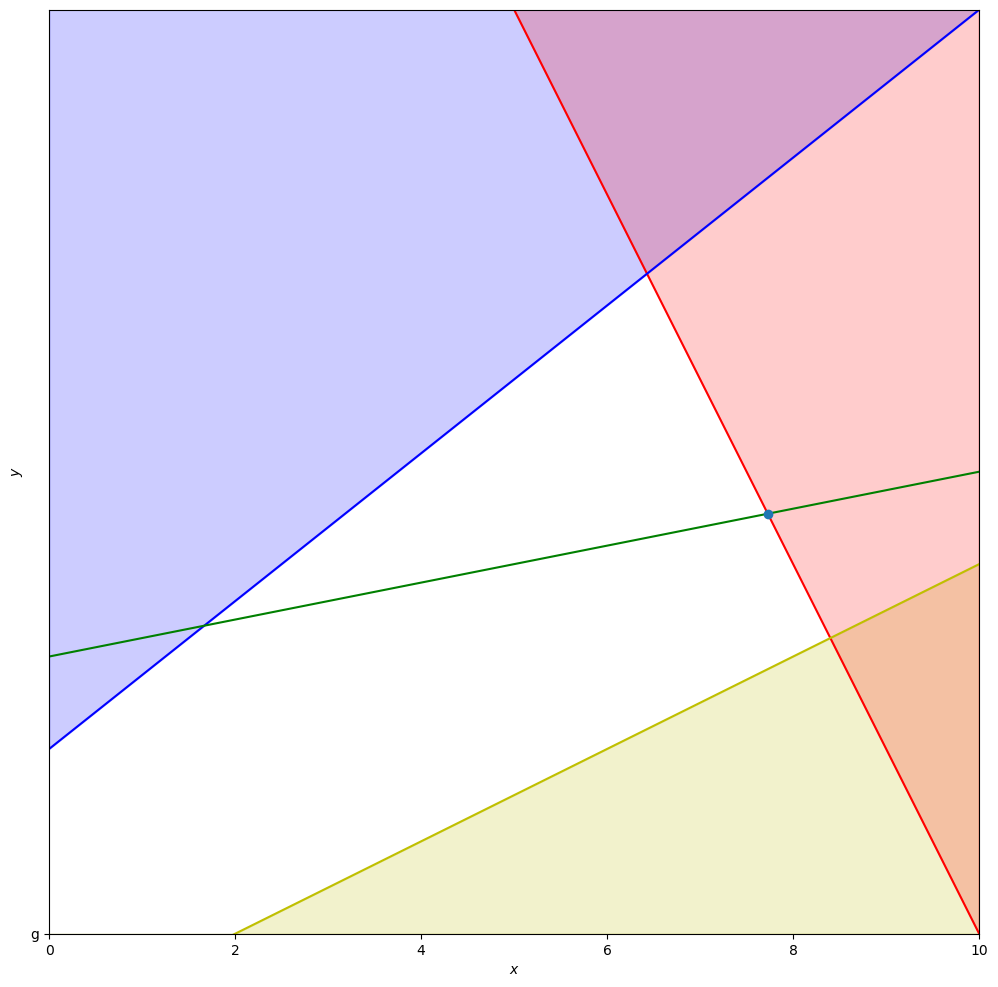

In [34]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Define the lines forming the boundary
def f1(x):
    return 20 - 2*x
def f2(x):
    return (10 + 4*x)/5
def f3(x):
    return (-2 + x)/2
def f4(x):
    return (15+x)/5

# Setting bounds
xr = np.linspace(0,10,100)
y1 = 10


plt.figure(figsize=(12,12))

# plot boundry lines
plt.plot(xr,f1(xr),'r')
plt.plot(xr,f2(xr),'b')
plt.plot(xr,f3(xr),'y')
plt.plot(xr,f4(xr), 'g')

# plot solution
plt.plot(soln_2[0],soln_2[1],'o','g')

# fill constraints
plt.fill_between(xr, f3(xr), interpolate=True, color='y', alpha=0.2)
plt.fill_between(xr, f2(xr), np.max(y1), color='b', alpha=0.2)
plt.fill_between(xr, f1(xr), np.max(y1), color='r', alpha=0.2)



plt.xlim(0,10)
plt.ylim(0,10);
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

We can also use a package named `PuLP` which is less matrix and more "mathematically" oriented for input. Also, problems do not need to be cast solely as minimization problems in standard form.

In [35]:
# For the next part, we install PuLP, an alternative linear programming package
# using: !pip install pulp
from pulp import LpMaximize, LpProblem, LpStatus, lpSum, LpVariable

In [36]:
# Creates the 'prob' variable to contain the problem data
model = LpProblem(name="Simple-LP-problem",sense=LpMaximize)

# ---------------------
# VARIABLES
# ---------------------
x = LpVariable(name='x', lowBound=0)
y = LpVariable(name='y', lowBound=0)

# ---------------------
# OBJECTIVE
# ---------------------
model += x + 2 * y

# ---------------------
# CONSTRAINTS
# ---------------------
model += (2 * x + y <= 20, 'red constraint')
model += (4 * x - 5 + y >= -10, 'blue constraint')
model += (-x + 2 * y >= -2, 'yellow constraint')
model += (-x + 5 * y == 15, 'green constraint')

We can see the problem as formulated:

In [37]:
model

Simple-LP-problem:
MAXIMIZE
1*x + 2*y + 0
SUBJECT TO
red_constraint: 2 x + y <= 20

blue_constraint: 4 x + y >= -5

yellow_constraint: - x + 2 y >= -2

green_constraint: - x + 5 y = 15

VARIABLES
x Continuous
y Continuous

And solve the problem with a bit more information in the result.

In [38]:
# Solve the problem
status = model.solve()

# And print the results
print(f"status: {model.status}, {LpStatus[model.status]}")

print(f"objective: {model.objective.value()}")

for var in model.variables():
    print(f"{var.name}: {var.value()}")
    
for name, constraint in model.constraints.items():
    print(f"{name}: {constraint.value()}")

status: 1, Optimal
objective: 16.8181817
x: 7.7272727
y: 4.5454545
red_constraint: -9.99999993922529e-08
blue_constraint: 40.4545453
yellow_constraint: 3.3636362999999996
green_constraint: -2.0000000233721948e-07


We can also modify the problem to a **mixed integer** linear programming problem:
$$
\max_{x,y} x + 2 y
$$
subject to:
$$
\begin{aligned} 
 2 x + y &\le 20\;\;\; \text{red constraint}
\\
 -4x + 5y &\le 10\;\;\; \text{blue constraint}
\\
 -x + 2y &\le -2\;\;\;  \text{yellow constraint}
\\
-x +5 y &= 15\;\;\;  \text{green line}
\\
x \geq 0, \;\; y &\geq 0
\\
x \in \mathbb{N}
\end{aligned}
$$

We can plot this:


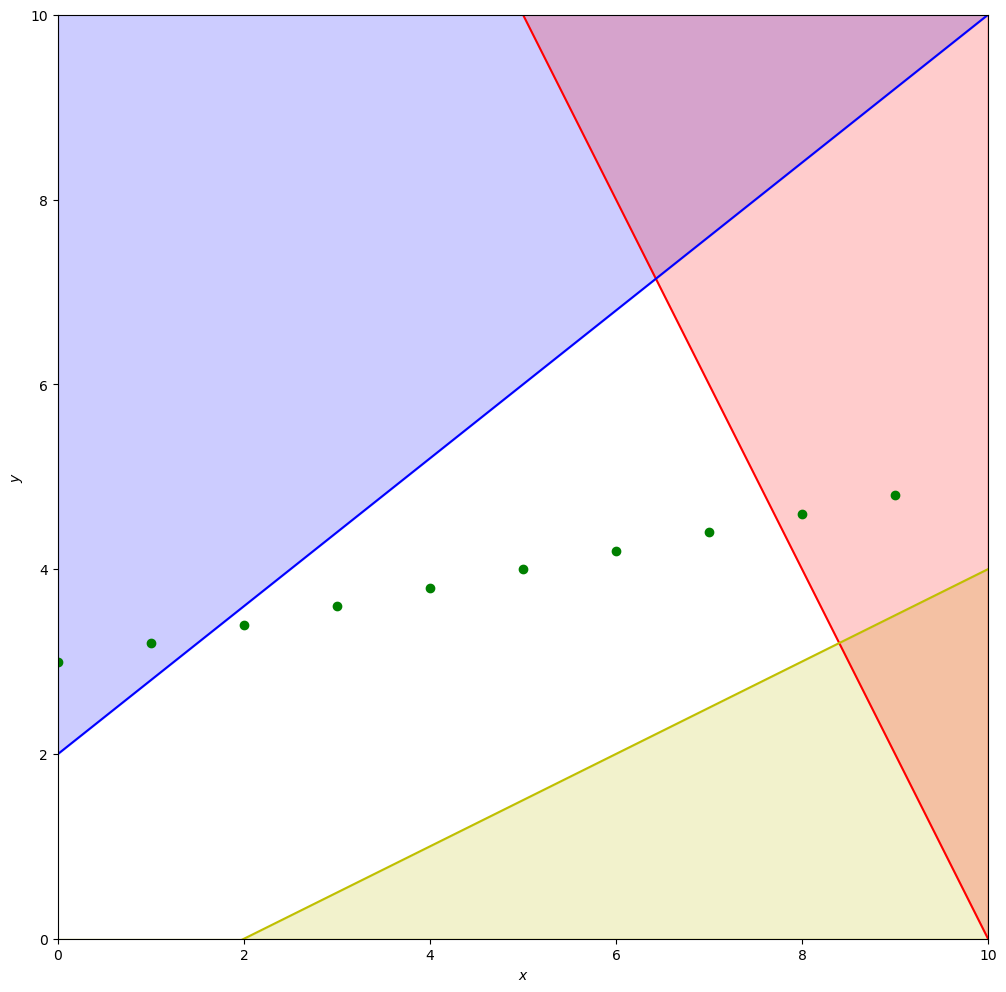

In [39]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Define the lines forming the boundary
def f1(x):
    return 20 - 2*x
def f2(x):
    return (10 + 4*x)/5
def f3(x):
    return (-2 + x)/2
def f4(x):
    return (15+x)/5

# Setting bounds
xr = np.linspace(0,10,100)
x = np.arange(0,10)
y1 = 10


plt.figure(figsize=(12,12))

# plot boundry lines
plt.plot(xr,f1(xr),'r')
plt.plot(xr,f2(xr),'b')
plt.plot(xr,f3(xr),'y')
plt.plot(x, f4(x), 'o', color ='g')

# fill constraints
plt.fill_between(xr, f3(xr), interpolate=True, color='y', alpha=0.2)
plt.fill_between(xr, f2(xr), np.max(y1), color='b', alpha=0.2)
plt.fill_between(xr, f1(xr), np.max(y1), color='r', alpha=0.2)



plt.xlim(0,10)
plt.ylim(0,10);
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

And solve it using `PuLP`.

In [40]:
# Creates the 'prob' variable to contain the problem data
model = LpProblem(name="Simple-LP-problem",sense=LpMaximize)

# ---------------------
# VARIABLES
# ---------------------
x = LpVariable(name='x', lowBound=0, cat='Integer')
y = LpVariable(name='y', lowBound=0)

# ---------------------
# OBJECTIVE
# ---------------------
model += x + 2 * y

# ---------------------
# CONSTRAINTS
# ---------------------
model += (2 * x + y <= 20, 'red constraint')
model += (4 * x - 5 + y >= -10, 'blue constraint')
model += (-x + 2 * y >= -2, 'yellow constraint')
model += (-x + 5 * y == 15, 'green constraint')

In [41]:
# Solve the problem
status = model.solve()

# And print the results
print(f"status: {model.status}, {LpStatus[model.status]}")

print(f"objective: {model.objective.value()}")

for var in model.variables():
    print(f"{var.name}: {var.value()}")

for name, constraint in model.constraints.items():
    print(f"{name}: {constraint.value()}")

status: 1, Optimal
objective: 15.8
x: 7.0
y: 4.4
red_constraint: -1.5999999999999996
blue_constraint: 37.4
yellow_constraint: 3.8000000000000007
green_constraint: 0.0


Let's take a look at all three solutions.

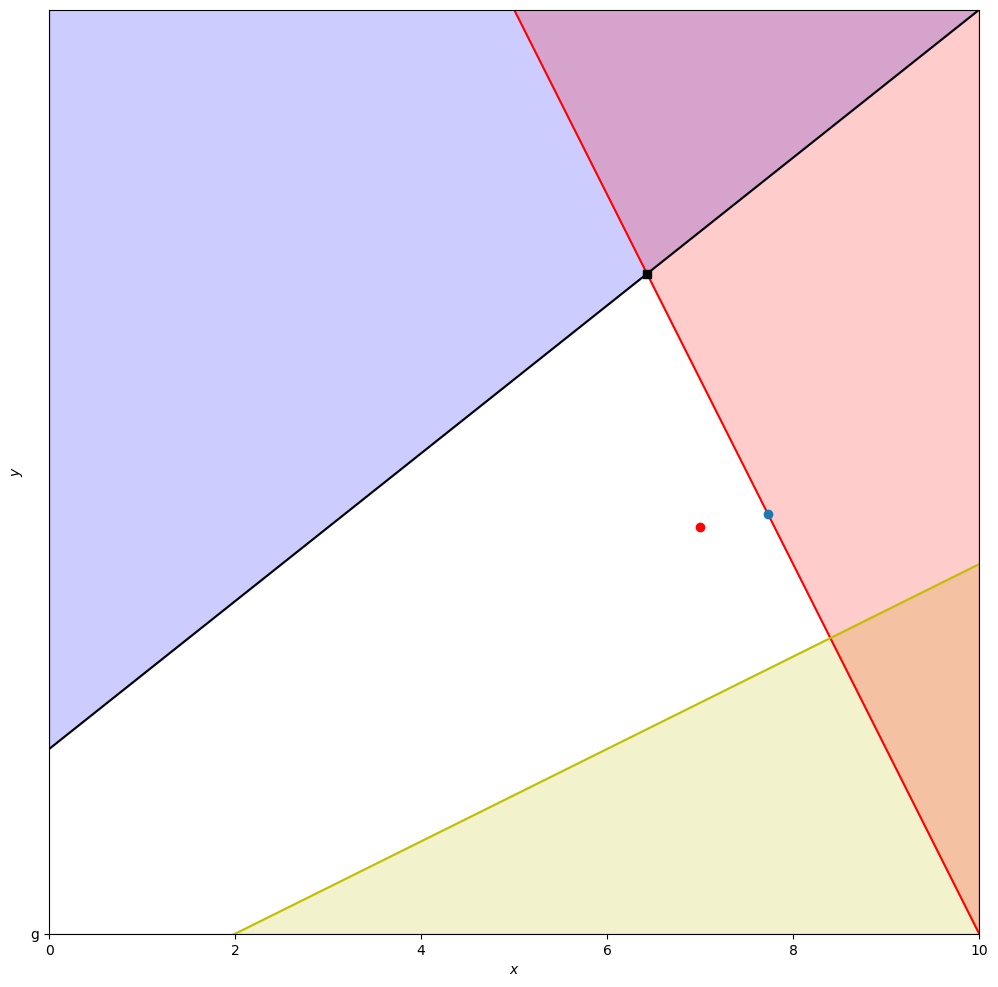

In [42]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Define the lines forming the boundary
def f1(x):
    return 20 - 2*x
def f2(x):
    return (10 + 4*x)/5
def f3(x):
    return (-2 + x)/2
def f4(x):
    return (15+x)/5

# The three solutions
soln_1 = np.array([6.42857143, 7.14285714])
soln_2 = np.array([7.72727273, 4.54545455])
soln_3 = np.array([7.0, 4.4])

# Setting bounds
xr = np.linspace(0,10,100)
y1 = 10


plt.figure(figsize=(12,12))

# plot boundry lines
plt.plot(xr,f1(xr),'r')
plt.plot(xr,f2(xr),'k')
plt.plot(xr,f3(xr),'y')

# plot solutions
plt.plot(soln_1[0],soln_1[1],'s',color = 'k')
plt.plot(soln_2[0],soln_2[1],'o','g')
plt.plot(soln_3[0],soln_3[1],'o',color = 'r')

# fill constraints
plt.fill_between(xr, f3(xr), interpolate=True, color='y', alpha=0.2)
plt.fill_between(xr, f2(xr), np.max(y1), color='b', alpha=0.2)
plt.fill_between(xr, f1(xr), np.max(y1), color='r', alpha=0.2)

plt.xlim(0,10)
plt.ylim(0,10);
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

## Asset Liability Management: Cash-Flow Matching

Asset Liability Management (ALM) is the practice of managing a business so that decisions and actions taken with respect to assets and liabilities are coordinated. It's the sound management of the finances to match the asset cash flows with its future liability cash flow needs and capital requirements. 

ALM practice takes into account a wide range of risks: liquidity, interest rate, equity, currency, legal, demographic, etc.




We will be considering the interest rate risk part of the ALM.

* ALM usually takes the form of "immunization": matching the present value, duration and convexity of the liabilities and assets in the portfolio. This is typically done at each time bucket of the planning horizon.

* Here, we will focus on the form of "dedication": choose an investment asset portfolio such that, for each period of the planning horizon, the investment cash flow will be sufficient to meet the projected liability cash flows. This is also known as "defeasement".




### Basic Setup for "Dedication"

Given:

*  $t_k, \;\; k = 1,\dots, K $ are the time periods
*  $L_k, \;\; k = 1,\dots, K $ are the future liability payment at time $t_k$

*  $P_j, \;\; j = 1,\dots, N $ are the prices of $N$ investable assets
*  $C_{j, k}, \;\; j = 1,\dots, N, \;\; k= 1, \dots, K $ are the cash flows of asset $j$ at time  period $t_k$


Assuming:

*  $x_j, \;\; j = 1,\dots, N $ are the amount to be invested in asset $j$








The problem is to find the asset portfolio such that the total cost

$$
\sum_j x_j P_j 
$$

is minimized, while the projected liability cash flows are covered by the cash flows generated by the asset portfolio

$$
\sum_j x_j C_{j,k} \geq L_k \;\;  k = 1,\cdots,K
$$

and $x_j \geq 0$.






### Example



* A pension fund has estimated that for the next 8 years it has the following schedule of benefits to be paid (in $millions ):


|  Years | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 |
| :-----: | :----: | :----: | :----: | :----: | :----: | :----: | :----: | :----: |
|  Benefits($millions) | 12 | 18 | 20 | 20 | 16 | 15 | 18 | 20 |

* The fund's investment advisors recommended the following set of bonds to invest:

|  Bonds | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 |
| :-----: | :----: | :----: | :----: | :----: | :----: | :----: | :----: | :----: | :----: | :----: |
|  Price | 102 | 99 | 101 | 98 | 98 | 104 | 100 | 101 | 102 | 94 |
|  Coupon(%) | 5 | 6.5 | 5 | 3.5 | 4 | 9 | 6 | 8 | 9 | 7 |
|  Maturity(Years) | 1 | 2 | 2 | 3 | 4 | 5 | 5 | 6 | 7 | 8 |

* The bonds all have face values $\$100$, the coupons are annualized percentage.

* Can you find the **least costly** portfolio of bonds so that the pension fund can meet its future benefit payments?


### LP formulation set up:


* $L_k, k = 1,\cdots, 8 $ are the future benefits (liabilities) payment at year $k$
* $P_i, i = 1,\cdots, 10 $ are the prices of bond $i$
* $C_i, i = 1,\cdots, 10 $ are the coupons of bond $i$
* $M_i, i = 1,\cdots, 10 $ are the maturity of bond $i$


* We will assume the variables are:
    * $x_i, i = 1,\cdots, 10 $ are the amount of bond $i$ to be purchased
    * $s_k, k = 1,\cdots, 8 $ are the free cash at the end of year $k$ 





The LP problem can be formulated as:

$$
\min_{\mathbf{x}} \left( \sum_i x_i P_i \right)
$$

$$
\begin{aligned}
s.t. & \sum_{i=1,\cdots,10} ({\bf 1}_{M_i\geq k}\cdot C_i(t) + {\bf 1}_{M_i=k}\cdot 100)\; x_i - s_k + s_{k-1}= L_k, \;\;  k = 1,2,\cdots, 8
\\
     & x_i \geq 0 \;\; i = 1,2,\cdots, 10; \;\;\; s_k \geq 0 \;\;  k = 1,2,\cdots, 8
\end{aligned}
$$

where we assume $s_0 = 0$.

In [43]:
p = np.array([102, 99, 101, 98, 98, 104, 100, 101, 102, 94]) # price of bonds
b = np.array([12, 18, 20, 20, 16, 15, 18, 20]) # pension obligations
A = [[100+5, 6.5, 5, 3.5, 4, 9, 6, 8, 9, 7], 
     [0, 100+6.5, 100+5, 3.5, 4, 9, 6, 8, 9, 7],  
     [0, 0, 0, 100+3.5, 4, 9, 6, 8, 9, 7],  
     [0, 0, 0, 0, 100+4, 9, 6, 8, 9, 7],  
     [0, 0, 0, 0, 0, 100+9, 100+6, 8, 9, 7],  
     [0, 0, 0, 0, 0, 0, 0, 100+8, 9, 7],  
     [0, 0, 0, 0, 0, 0, 0, 0, 100+9, 7],  
     [0, 0, 0, 0, 0, 0, 0, 0, 0, 100+7] ]

res = linprog(p, A_eq=A, b_eq=b,
                options={ 'disp': True})

np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)
print("The solution from Scipy Simplex method:\n", res.x)


The solution from Scipy Simplex method:
 [0.0527 0.1154 0.     0.1429 0.1479 0.1138 0.     0.114  0.1531 0.1869]


Look at the number of bonds we need to buy -- they seem a little small don't they?

In [44]:
p = np.array([102, 99, 101, 98, 98, 104, 100, 101, 102, 94]) # price of bonds
b = np.array([12e6, 18e6, 20e6, 20e6, 16e6, 15e6, 18e6, 20e6]) # pension obligations
A = [[100+5, 6.5, 5, 3.5, 4, 9, 6, 8, 9, 7], 
     [0, 100+6.5, 100+5, 3.5, 4, 9, 6, 8, 9, 7],  
     [0, 0, 0, 100+3.5, 4, 9, 6, 8, 9, 7],  
     [0, 0, 0, 0, 100+4, 9, 6, 8, 9, 7],  
     [0, 0, 0, 0, 0, 100+9, 100+6, 8, 9, 7],  
     [0, 0, 0, 0, 0, 0, 0, 100+8, 9, 7],  
     [0, 0, 0, 0, 0, 0, 0, 0, 100+9, 7],  
     [0, 0, 0, 0, 0, 0, 0, 0, 0, 100+7] ]

res = linprog(p, A_eq=A, b_eq=b,
                options={ 'disp': True})

np.set_printoptions(precision=0)
np.set_printoptions(suppress=True)
print("The solution from Scipy Simplex method:\n", res.x)

The solution from Scipy Simplex method:
 [ 52724. 115360.      0. 142859. 147859. 113773.      0. 114013. 153134.
 186916.]


Hmm, we got and interesting message...

In [45]:
p = np.array([102, 99, 101, 98, 98, 104, 100, 101, 102, 94]) # price of bonds
b = np.array([12e6, 18e6, 20e6, 20e6, 16e6, 15e6, 18e6, 20e6]) # pension obligations
A = [[100+5, 6.5, 5, 3.5, 4, 9, 6, 8, 9, 7], 
     [0, 100+6.5, 100+5, 3.5, 4, 9, 6, 8, 9, 7],  
     [0, 0, 0, 100+3.5, 4, 9, 6, 8, 9, 7],  
     [0, 0, 0, 0, 100+4, 9, 6, 8, 9, 7],  
     [0, 0, 0, 0, 0, 100+9, 100+6, 8, 9, 7],  
     [0, 0, 0, 0, 0, 0, 0, 100+8, 9, 7],  
     [0, 0, 0, 0, 0, 0, 0, 0, 100+9, 7],  
     [0, 0, 0, 0, 0, 0, 0, 0, 0, 100+7] ]

res = linprog(p, A_eq=A, b_eq=b,
                options={ 'disp': True},method='revised simplex')

np.set_printoptions(precision=0)
np.set_printoptions(suppress=True)
print("The solution from Scipy Simplex method:\n", res.x)


Phase Iteration Minimum Slack       Constraint Residual Objective          
1     0         NA                  40734158.14086      27956208.2777       
1     1         NA                  34100907.7718       42237032.86339      
1     2         NA                  29986543.34782      52866284.89135      
1     3         NA                  25531879.36215      63703997.36753      
1     4         NA                  19547413.3582       77619629.44479      
1     5         NA                  12285881.30385      91134073.15823      
1     6         NA                  5.587935447693e-09  101826333.1045      
2     6         NA                  5.587935447693e-09  101826333.1045      
Optimization terminated successfully.
         Current function value: 101826333.104484
         Iterations: 6
The solution from Scipy Simplex method:
 [ 52724. 115360.      0. 142859. 147859. 113773.      0. 114013. 153134.
 186916.]


### Extensions of the Asset liability cash flow matching problem


The constraint condition can be turned into equality based by assuming the surplus free cash flow at each time period and consider them to be variables

*  $s_k, \;\; k = 1,\cdots, K $ are the amount of excess cash after paying the liability

With that, the constraints are now

$$
\sum_j x_j C_{j,k} - s_k = L_k, \;\;  k = 1,\cdots,K
$$
and $x_j \geq 0, \;\; s_k \geq 0$.





* With these excess cash flows, it is then natural to assume that they will be re-invested, and the return is simply $r$, therefore the constraints becomes

$$
\sum_j x_j C_{j,k} - s_k + (1+r) \cdot s_{k-1} = L_k, \;\;  k = 1,\cdots,K
$$
where we set $s_0 = 0$.


* The setup can be made even more realistic  by allowing the reinvestment return to be time period dependent: $r \rightarrow r_k$

* In fact, if borrowing is allowed, the constraints $ s_k \geq 0$ for all time periods are unnecessary, except we probably want to keep the excess cash to be positive at the very last time period.

* Which introduces another dimension: the borrowing rate and lending (re-investment) rate are typically different in real life. 

* In practice, these assumptions (or approximations) can certainly make a big difference in terms of the complexity and realistism of your model.





### Undeterministic future liabilities and asset returns

* Cash flow matching so far require the cash flows from the liabilities can be forcasted deterministically

* This is hardly the case: liabilities of insurance companies are not fixed
    * Policyholders can withdraw cash
    * Hurricane frequency and severity are highly unpredictable
    * Pension payments are hardly deterministic




# Fitting the Volatility Surface

The volatility surface is a three-dimensional plot of the implied volatility of a stock option.
If the Black-Scholes model were completely correct, then the implied volatility surface across strike prices and time to maturity should be flat. In practice, this is not the case.

The volatility surface is far from flat and often varies over time because the assumptions of the Black-Scholes model are not always true. For instance, options with lower strike prices tend to have higher implied volatilities than those with higher strike prices.

As the time to maturity approaches infinity, volatilities across strike prices tend to converge to a constant level. However, the volatility surface is often observed to have an inverted volatility smile. Options with a shorter time to maturity have multiple times the volatility compared to options with longer maturities. This observation is seen to be even more pronounced in periods of high market stress. It should be noted that every option chain is different, and the shape of the volatility surface can be wavy across strike price and time. Also, put and call options usually have different volatility surfaces.

The widespread practice of quoting option prices
in terms of their Black-Scholes implied volatilities
in no way implies that market participants
believe underlying returns to be lognormal. On the
contrary, the variation of implied volatilities across option strike
and term to maturity, which is widely referred to
as the volatility surface, can be substantial.

Remember, building an implied volatility surface is much more [complicated](https://tsimagine.com/2020/09/thinking-about-building-a-volatility-surface-think-again/) than what we do below.

## Downloading the Options Data

In [46]:
import pandas as pd
import numpy as np
import yfinance as yf
import datetime
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import MaxNLocator
import warnings
warnings.simplefilter("ignore")
%matplotlib inline

In [51]:
def get_options(ticker):
    
    #####################################################
    # 
    # retrieves options data (calls and puts) for all 
    # expirations from Yahoo Finance for a given ticker
    #
    # input: ticker for options of interest
    #         e.g. get_options('^spx')
    #          will retrieve calls and puts 
    #           on the SP500 index
    #
    # returns: two DataFrames one for calls; one for puts
    #     
    # usage: calls,puts = get_options('^spx')
    #
    # Written by RRL 2/18/2022
    #
    ########################################################
    
    # necessary packages
    import pandas as pd
    import yfinance as yf
    
    # get the data for the ticker from Yahoo
    optionTicker= yf.Ticker(ticker)

    # initialize DataFrames
    callOptions = pd.DataFrame()
    putOptions = pd.DataFrame()

    # cycle through the available expiration dates collecting
    # the option information
    for expry in optionTicker.options:
        try:
        #print(expry)  # date can be printed as cycle through
            opt = optionTicker.option_chain(expry)
            temp_call = pd.DataFrame(opt.calls)
            temp_put = pd.DataFrame(opt.puts)
            temp_call['expry'] = expry # add column for expiry date
            temp_put['expry'] = expry # add column for expiry date
            callOptions = callOptions._append(temp_call)
            putOptions = putOptions._append(temp_put)
            
        except ValueError: # need ValueError since Yahoo sometimes includes dates that have no options
            pass
    
    # rest the indices in the DataFrames
    callOptions = callOptions.reset_index()
    putOptions = putOptions.reset_index()
    
    # return two DataFrames
    return(callOptions,putOptions)

In [52]:
calls,puts = get_options('AAPL')

In [53]:
# Drop unnecessary and meaningless columns and dates when open interest is zero
calls = calls.drop(columns = ['index','contractSymbol', 'currency', 'change', 'percentChange', 'contractSize', 'lastTradeDate'])
calls  = calls[calls['openInterest']>0]
calls.reset_index(drop=True, inplace=True)

In [54]:
calls = calls[0:624]
calls

,strike,lastPrice,bid,ask,volume,openInterest,impliedVolatility,inTheMoney,expry
0,100.0,73.20,69.25,70.20,2.0,2.0,1.722658,True,2024-04-12
1,105.0,66.79,64.25,65.20,NaN,2.0,1.578127,True,2024-04-12
2,120.0,52.35,49.30,50.25,6.0,21.0,1.234379,True,2024-04-12
3,125.0,44.99,44.05,45.25,2.0,1.0,0.957032,True,2024-04-12
4,130.0,41.70,39.30,40.25,3.0,3.0,0.983399,True,2024-04-12
...,...,...,...,...,...,...,...,...,...
619,80.0,93.08,91.10,93.10,1.0,456.0,0.623417,True,2025-01-17
620,85.0,87.39,86.30,88.40,10.0,374.0,0.595219,True,2025-01-17
621,90.0,83.40,82.25,83.70,2.0,621.0,0.586247,True,2025-01-17
622,95.0,80.40,77.60,78.90,1.0,2657.0,0.558110,True,2025-01-17


In [62]:
# Convert the date to a number
date = calls['expry'].str.replace('-','').astype(int)/10000

In [75]:
X = calls['strike']
Y = date
Z = calls['impliedVolatility']


In [76]:
def make_surf(X,Y,Z):
    XX,YY = np.meshgrid(np.linspace(min(X),max(X),100),np.linspace(min(Y),max(Y),100))
    ZZ = griddata(np.array([X,Y]).T,np.array(Z),(XX,YY), method='linear')
    ZZ = np.nan_to_num(ZZ,0.1)
    return XX,YY,ZZ

In [77]:
XX,YY,ZZ = make_surf(X,Y,Z)

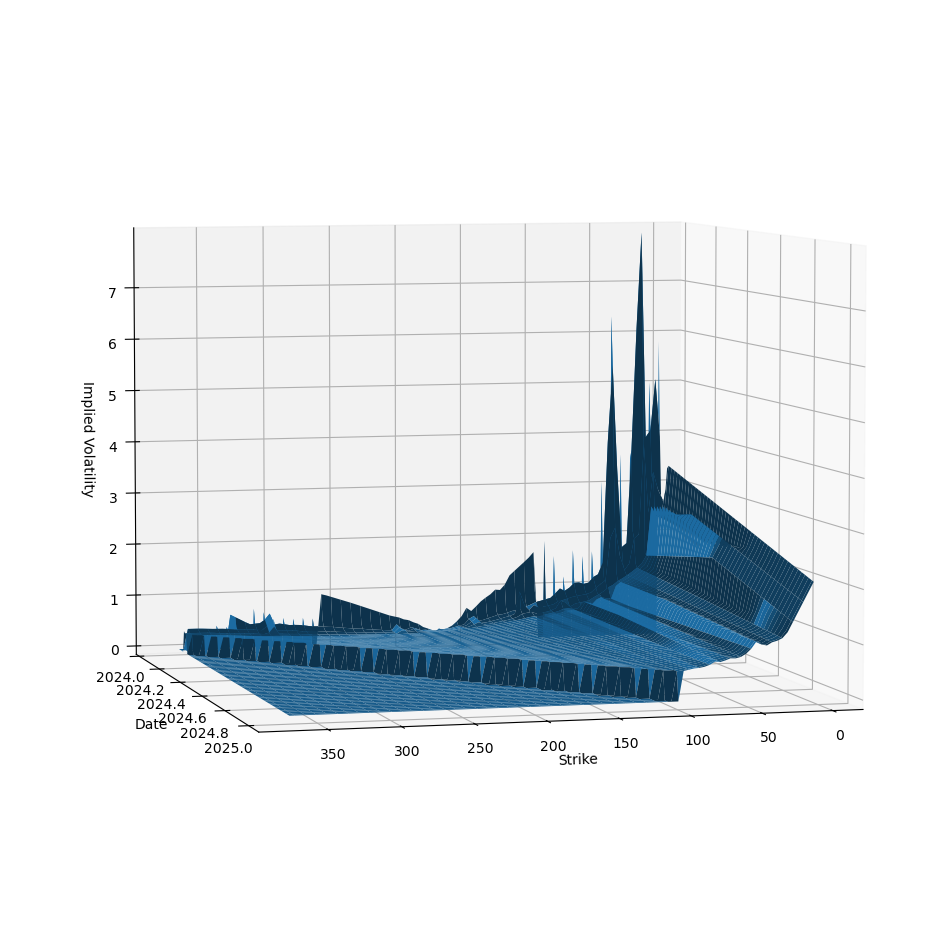

In [99]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')

# Set the azimuth angle to 75 degrees and the elevation angle to 5 degrees
ax.view_init(elev=5, azim=75)

ax.plot_surface(XX, YY, ZZ)

# Set the labels for the axes
ax.set_xlabel('Strike')
ax.set_ylabel('Date')
ax.set_zlabel('Implied Volatility')


plt.show()

